# Underlying Price Distribution From Options Prices

## Environment setup and imports

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

## Utility Functions

In [40]:
def discrete_expectation(f, dist):
    outputs = f(dist["x"].values) * dist["pdf"].values
    average_outputs = (outputs[:-1] + outputs[1:]) / 2
    dx = dist["x"][1:].values - dist["x"][:-1].values
    return (average_outputs * dx).sum()

In [114]:
def create_normal_distribution(mu=0, sigma=1, max_x=100, N=1000):
    pdf = lambda x: 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-(x - mu) * (x - mu) / (2 * sigma * sigma))
    x_range = np.linspace(-max_x, max_x, N)
    dist = pd.DataFrame({
        "x": x_range,
        "pdf": pdf(x_range)
    })
    return dist

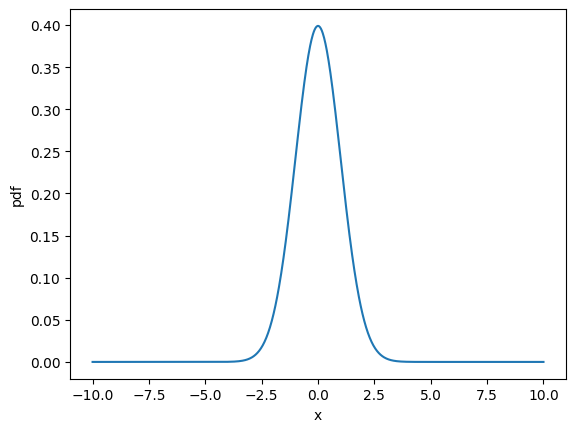

In [150]:
dist = create_normal_distribution(0, 1, max_x=10)
plt.xlabel("x")
plt.ylabel("pdf")
plt.plot(dist["x"], dist["pdf"])
plt.show()

In [151]:
norm = discrete_expectation(np.vectorize(lambda x: 1), dist)
print("Normalization:", norm)

expectation = discrete_expectation(lambda x: x, dist)
print("Expectation:", expectation)

variance = discrete_expectation(lambda x: (x - expectation) ** 2, dist)
print("Variance:", variance)

Normalization: 1.0
Expectation: 0.0
Variance: 1.0


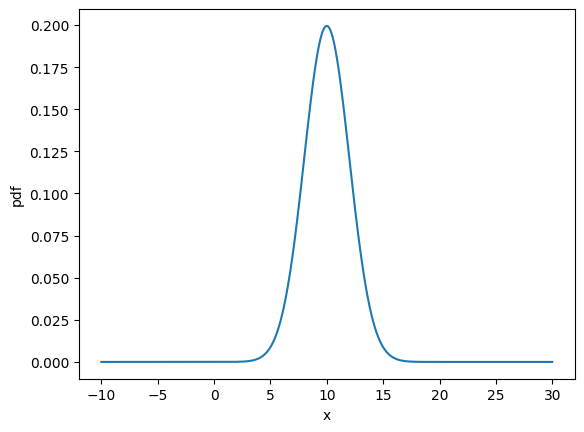

In [161]:
n_dist = dist.copy()
n_mu = 10
n_sigma = 2
n_dist["x"] = n_dist["x"] * n_sigma + n_mu
n_dist["pdf"] = n_dist["pdf"] / n_sigma

plt.xlabel("x")
plt.ylabel("pdf")
plt.plot(n_dist["x"], n_dist["pdf"])
plt.show()

In [162]:
norm = discrete_expectation(np.vectorize(lambda x: 1), n_dist)
print("Normalization:", norm)

expectation = discrete_expectation(lambda x: x, n_dist)
print("Expectation:", expectation)

variance = discrete_expectation(lambda x: (x - expectation) ** 2, n_dist)
print("Variance:", variance)

Normalization: 1.0
Expectation: 10.000000000000002
Variance: 4.000000000000001


## Options Pricing Model

Let's say you have an option with some payout function: $p(x)$. For example, a call option with strike $K$ has a payout $p(x) = \max(0, x - K)$.

Let's say this is a European option that can only be exercised on expiration for simplicity. Let the expiration be $T$ years away. Let the underlying price at any time $U_t$ be distributed according to
$$ U_t \sim f(x) = \frac{1}{\sigma\sqrt{T}} D_{\vec{\theta}}\big(\frac{x-U_0}{\sigma\sqrt{T}}\big) $$

where $D_{\vec{\theta}}$ is some distribution fully parameterized by $\theta$ and has the following properties (let $S \sim D_{\vec{\theta}}(x)$):

* $E[S] = 0$
* $Var(S) = Std(S) = 1$

As a result,
* $E[U_t] = U_0$
* $Std(U_t) = \sigma \sqrt{t}$ and $Var(U_t) = \sigma^2 t$

So, $\sigma$ represents the annual standard deviation of the underlying. I will refer to this as the volatility for this work even though it is not in log space. Now the price of the this option $\Phi$ with expiration $T$ should be as follows:

$$ (1+r)^T\Phi_T = E[p(U_T)] \rightarrow \Phi_T = \frac{E[p(U_T)]}{(1+r)^T} $$

where $r$ is the risk free interest rate.

$$ \Phi_T = \frac{1}{(1+r)^T}\int_{-\infty}^{\infty} p(x) \frac{1}{\sigma\sqrt{T}} D_{\vec{\theta}}\big(\frac{x-U_0}{\sigma\sqrt{T}}\big)dx $$
$$ \Phi_T = \frac{1}{(1+r)^T \sigma\sqrt{T}}\int_{-\infty}^{\infty} p(x) D_{\vec{\theta}}\big(\frac{x-U_0}{\sigma\sqrt{T}}\big)dx $$

Thus, we have a formula for an option price, given a payout function $p(x)$, the normalized distribution of the underlying price $D_{\vec{\theta}}$, the current underlying price $U_0$, the underlying price annual standard deviation $\sigma$, the time till expiration $T$ in years, and the risk free interest rate $r$.

Note that we can use a change of variable $z = \frac{x-U_0}{\sigma\sqrt{T}}$ and $dx = \sigma\sqrt{T} dz$ to simply this equation to
$$ \Phi_T = \frac{1}{(1+r)^T}\int_{-\infty}^{\infty} p(\sigma\sqrt{T}z + U_0) D_{\vec{\theta}}(z)dz $$


In [239]:
def price_option(payout, normalized_distribution, current_underlying_price, underlying_sigma, expiration_time, interest_rate):
    if expiration_time > 0:
        phi_T = discrete_expectation(
            lambda z: payout(underlying_sigma * np.sqrt(expiration_time) * z + current_underlying_price),
            normalized_distribution
        ) / (1 + interest_rate) ** expiration_time
    else:
        phi_T = float(payout(current_underlying_price))
    return phi_T

Now, using this function, let us plot a call option price over the possible strikes and expiration times. Remember, the call option payout $p(x)$ for a given strike $K$ is $\max(0, x-K)$. To use the functions above, this must be written in a vectorized fashion using `np.where`. Let us also assume that the stock price follows a normal distribution for now.

In [240]:
call_option_payout = lambda k: (lambda x: np.where(x < k, 0, x - k))

In [241]:
dist = create_normal_distribution()
u_0 = 200
sigma = 20
r = 0.05

In [242]:
price_option(call_option_payout(201), dist, u_0, sigma, 1/12, r)

1.833227310991436

In [243]:
ks = np.linspace(180, 220, 40)
exp_t_months = [0, 0.25, 0.5, 1, 2, 3, 6, 12, 24]

option_prices = np.zeros((len(exp_t_months), len(ks)))

for i, exp_t_month in enumerate(exp_t_months):
    print(f"Calculating {exp_t_month} month option prices . . .")
    for j in tqdm(range(len(ks))):
        option_prices[i, j] = price_option(call_option_payout(ks[j]), dist, u_0, sigma, exp_t_month/12, r)

Calculating 0 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 39643.71it/s]


Calculating 0.25 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 5729.73it/s]


Calculating 0.5 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 7999.44it/s]


Calculating 1 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 3630.96it/s]


Calculating 2 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 5706.73it/s]


Calculating 3 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 4440.18it/s]


Calculating 6 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 6689.48it/s]


Calculating 12 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 6670.60it/s]


Calculating 24 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 9970.41it/s]


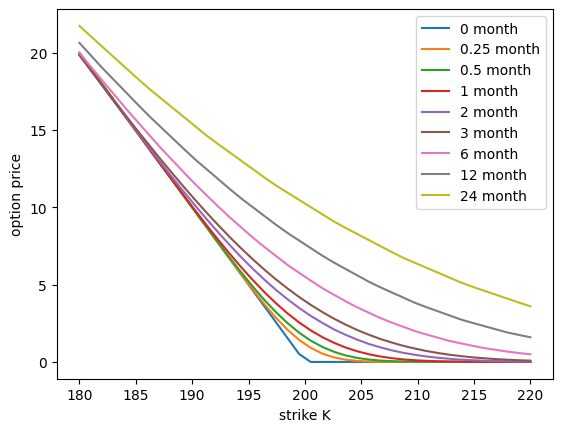

In [244]:
plt.xlabel("strike K")
plt.ylabel("option price")

for i, exp_t_month in enumerate(exp_t_months):
    plt.plot(ks, option_prices[i], label=f"{exp_t_month} month")

plt.legend()
plt.show()

This looks like a reasonable payout graph for an option with the given parameters.

## Next Thing Here